<img src="business.png" style="display:block; margin:auto" width=350>

<div align="center"> <h1 align="center"> Project: Customers and Products Analysis </h1> </div>

#### The Goal
Data analysis emerges as very good in enhancing sales effectiveness by extracting key performance indicators (`KPIs`) that inform strategic decision-making, resulting in significant time, resource, and cost savings.

Sales data analysis encompasses various dimensions, spanning sales, production, customer experience, and employee efficiency, thereby presenting diverse challenges. Such a project serves as a compelling demonstration of analytical skills. The objective of this project is to inspect data sourced from a database housing sales records for `scale model cars`, extracting actionable insights for decision support.

Effective analysis begins with well-defined questions. The following queries guide the investigation:

- Which products should we order more of or less of?
- How should we tailor marketing and communication strategies to customer behaviors?
- How much can we spend on acquiring new customers?

#### The Data
The `scale model cars` database schema is as follows:

<img src="assets/db.png" width="300" style="margin-left:auto; margin-right:auto" />

It contains eight tables:

- `Customers`: customer data
- `Employees`: all employee information
- `Offices`: sales office information
- `Orders`: customers' sales orders
- `OrderDetails:` sales order line for each sales order
- `Payments`: customers' payment records
- `Products`: a list of scale model cars
- `ProductLines`: a list of product line categories

The subsequent step involves loading the `SQL` extension and the project database.

Lets start!
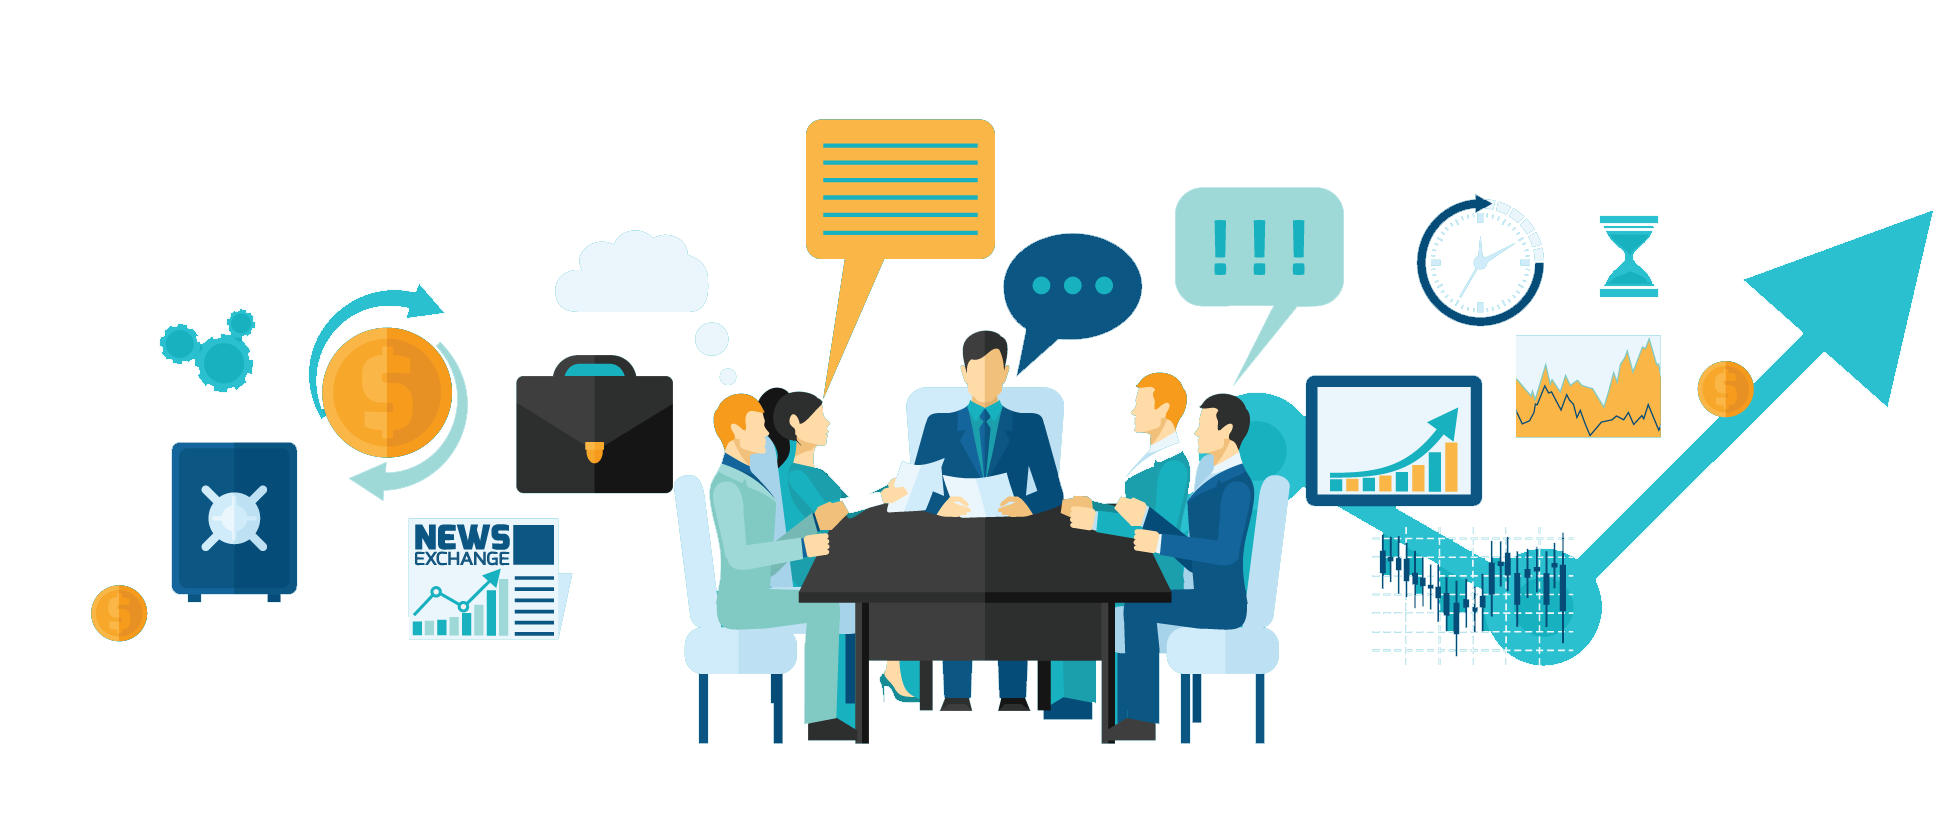
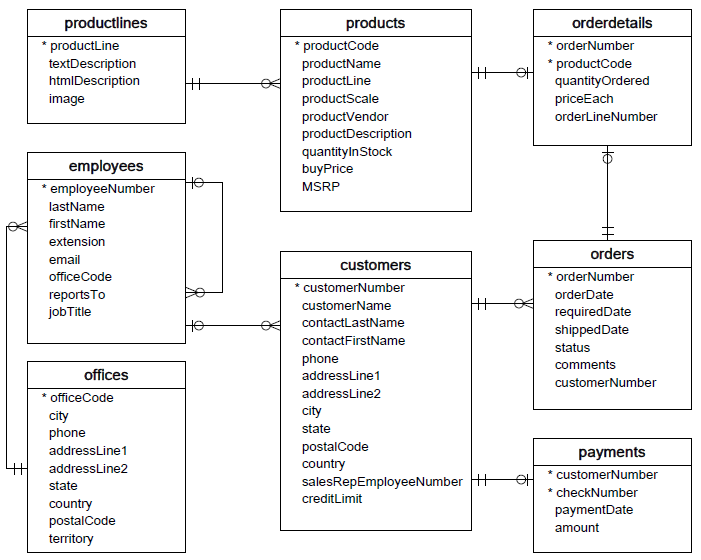

#### Load the Data

In [1]:
# Load the SQL extension
%load_ext sql

# Initiate the database
%sql sqlite:///stores.db

In [2]:
%%sql

SELECT 'Customers' AS table_name,
 13 AS number_of_attributes,
 COUNT(*) AS number_of_rows
  FROM customers

UNION ALL

SELECT 'Products',
  9 AS number_of_attributes,
 COUNT(*)
  FROM products
  
UNION ALL

SELECT 'ProductLines',
  4 AS number_of_attributes,
 COUNT(*)
  FROM productlines
  
UNION ALL

SELECT 'Orders',
  7 AS number_of_attributes,
 COUNT(*)
  FROM orders
  
UNION ALL

SELECT 'OrderDetails',
  5 AS number_of_attributes,
 COUNT(*)
  FROM orderdetails
  
UNION ALL

SELECT 'Payments',
  5 AS number_of_attributes,
 COUNT(*)
  FROM payments
  
UNION ALL

SELECT 'Employees',
  8 AS number_of_attributes,
 COUNT(*)
  FROM employees
  
UNION ALL

SELECT 'Offices',
  9 AS number_of_attributes,
 COUNT(*)
  FROM offices

 * sqlite:///stores.db
Done.


table_name,number_of_attributes,number_of_rows
Customers,13,122
Products,9,110
ProductLines,4,7
Orders,7,326
OrderDetails,5,2996
Payments,5,273
Employees,8,23
Offices,9,7


Observing the database composition, it comprises eight tables, each serving a distinct purpose. The `Customer` table exhibits the highest attribute count at 13, while the `ProductLines` table has the fewest attributes, totaling four. In terms of row count, the `OrderDetails` table boasts the highest volume with 2996 rows. In contrast, the `ProductLines` and `Office` tables exhibit the lowest row counts, both standing at 7.





#### Which Products Should We Order More of or Less of?

Now equipped with a deeper understanding of the database, we can address the first question: which products should we order more of or less of? 

This query delves into inventory reports, encompassing considerations of `low stock` indicative of `high demand` and overall `product performance`. The aim is to optimize supply management and enhance user experience by prevent stockouts of popular products.

- The `low stock` represents the quantity of the sum of each product ordered divided by the quantity of product in stock. We can consider the ten highest rates. These will be the top ten products that are almost out-of-stock or completely out-of-stock.
- Product performance is measured by the cumulative sales per product.
- A strategic approach to restocking prioritizes products with elevated product performance that are on the brink of being out of stock.

`low stock` will be calculated by dividing the sum of the `quantityOrdered` by the `quantityInStock`. `product performance` will be calculated by the sum of `quantityOrdered` multiplied by `priceEach`.

First, we compute the `low stock` for each product using a correlated subquery.

In [3]:
%%sql --- '# Query the top 10 low stock products'

SELECT ord.productCode, prod.productLine, ROUND(SUM(quantityOrdered) * 1.0 / (SELECT quantityInStock 
                                                          FROM products AS prod
                                                         WHERE ord.productCode = prod.productCode), 2) AS low_stock
  FROM orderdetails AS ord
  JOIN products AS prod
    ON ord.productCode = prod.productCode
 GROUP BY ord.productCode
 ORDER BY low_stock DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


productCode,productLine,low_stock
S24_2000,Motorcycles,67.67
S12_1099,Classic Cars,13.72
S32_4289,Vintage Cars,7.15
S32_1374,Motorcycles,5.7
S72_3212,Ships,2.31
S700_3167,Planes,1.9
S50_4713,Motorcycles,1.65
S18_2795,Vintage Cars,1.61
S18_2248,Vintage Cars,1.54
S700_1938,Ships,1.22


As evident from the presented data, the aforementioned values represent the top 10 instances of `low stock`. Particularly noteworthy is the elevated value (68) corresponding to the `productCode` `'S24_2000'`, which is a `Motorcycle`, suggesting a substantial frequency of orders for this product, side by side with a relatively `low stock` level. 

Subsequently, we proceed to calculate the `product performance` metric for each individual product.





In [4]:
%%sql --- '# Query the top 10 product performance products'

SELECT ord.productCode, prod.productLine,
       ROUND(SUM(quantityOrdered * priceEach), 0) AS performance
  FROM orderdetails AS ord
  JOIN products AS prod
    ON ord.productCode = prod.productCode
 GROUP BY ord.productCode
 ORDER BY performance DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


productCode,productLine,performance
S18_3232,Classic Cars,276840.0
S12_1108,Classic Cars,190756.0
S10_1949,Classic Cars,190018.0
S10_4698,Motorcycles,170686.0
S12_1099,Classic Cars,161531.0
S12_3891,Classic Cars,152543.0
S18_1662,Planes,144960.0
S18_2238,Classic Cars,142531.0
S18_1749,Vintage Cars,140536.0
S12_2823,Motorcycles,135767.0


Displayed above are the leading 10 products exhibiting the highest `performance` metrics. Notably, the product identified as `S18_3232`, which is a `Classic Car`, emerges as the top-performing product, achieving a cumulative value of $276,840.

Now let us Combine the previous queries using a `Common Table Expression` (CTE), to display priority products for restocking using the `IN` operator.

In [5]:
%%sql --- '# Using a Common Table Expression (CTE)' 

WITH 
low_stock_table AS (
SELECT productCode, 
       ROUND(SUM(quantityOrdered) * 1.0 / (SELECT quantityInStock
                                           FROM products AS prod
                                          WHERE ord.productCode = prod.productCode), 2) AS low_stock
  FROM orderdetails AS ord
 GROUP BY productCode
 ORDER BY low_stock DESC
 LIMIT 10)

--- '# Select productCode, productName and performance indicator, if productCode is in our CTE'
SELECT ord.productCode, productName, productLine,
       ROUND(SUM(quantityOrdered * priceEach), 0) AS performance
  FROM orderdetails ord
  JOIN products AS prod
    ON ord.productCode = prod.productCode
 WHERE ord.productCode IN (SELECT productCode
                         FROM low_stock_table)
 GROUP BY ord.productCode 
 ORDER BY performance DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


productCode,productName,productLine,performance
S12_1099,1968 Ford Mustang,Classic Cars,161531.0
S18_2795,1928 Mercedes-Benz SSK,Vintage Cars,132276.0
S32_1374,1997 BMW F650 ST,Motorcycles,89365.0
S700_3167,F/A 18 Hornet 1/72,Planes,76618.0
S50_4713,2002 Yamaha YZR M1,Motorcycles,73671.0
S700_1938,The Mayflower,Ships,69532.0
S24_2000,1960 BSA Gold Star DBD34,Motorcycles,67193.0
S32_4289,1928 Ford Phaeton Deluxe,Vintage Cars,60493.0
S72_3212,Pont Yacht,Ships,47550.0
S18_2248,1911 Ford Town Car,Vintage Cars,45307.0


The presented output showcases the `productCode`, `productName`, `productLine` and the `performance` indicator of the top 10 performing products that are currently facing low stock levels or complete depletion. Consequently, if possible, immediate restocking is recommended.

The product with the highest performance value is the `1968 Ford Mustang`, followed by the `1928 Mercedes-Benz SSK`. Given the vintage character of these cars, many people seem to like to buy a model of these cars, which illustrates their high `performance` values.

The product with the code `S700_3167` called `F/A 18 Hornet 1/72` is a fighting yet and the product with the code `S700_1938`, named `The Mayflower` is a sailing ship. Historically, `The Mayflower` refers to an English sailing ship that carried the Pilgrims from England to the New World in 1620 and was probably dismantled in 1624.





#### How Should We Match Marketing and Communication Strategies to Customer Behavior?

In the initial phase of this project, we delved into `product exploration`. Now, we proceed to examine `customer information` in response to the second question: How should we match marketing and communication strategies to customer behaviors? This involves categorizing customers, distinguishing `VIP` (Very Important Person) customers, who contribute significantly to profits, from those who exhibit lower engagement levels.

`VIP` customers are pivotal in generating substantial profits for the store, while `less-engaged` customers contribute to comparatively lower profits. For example, we could organize some events to drive loyalty for the VIPs and launch a campaign for the less engaged.

Before starting this analysis, let's calculate the profit generated by each customer.

In [6]:
%%sql --- '# Calcualte profit for each customer, show top 10' 

SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS profit
  FROM orders AS o
  JOIN orderdetails AS od
    ON o.orderNumber = od.orderNumber
  JOIN products AS p
    ON od.productCode = p.productCode
 GROUP BY o.customerNumber
 ORDER BY profit DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


customerNumber,profit
141,326519.66
124,236769.39
151,72370.09
114,70311.07
119,60875.3
148,60477.38
187,60095.86
323,60013.99
131,58669.1
450,55931.37


Using the profit per customer from the previous query, finding `VIP` customers is straightforward.






In [7]:
%%sql --- '# Top 10 VIP customers'
WITH 
vip_customers AS (
SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * 
                                       (od.priceEach - p.buyPrice)), 2) AS profit
  FROM orders AS o
  JOIN orderdetails AS od
    ON o.orderNumber = od.orderNumber
  JOIN products AS p
    ON od.productCode = p.productCode
 GROUP BY o.customerNumber
 ORDER BY profit DESC
    )
    
SELECT c.contactLastName, c.contactFirstName, c.city, c.country, vc.profit
  FROM customers AS c
  JOIN vip_customers AS vc
    ON c.customerNumber = vc.customerNumber
 ORDER BY vc.profit DESC
 LIMIT 10;

 * sqlite:///stores.db
Done.


contactLastName,contactFirstName,city,country,profit
Freyre,Diego,Madrid,Spain,326519.66
Nelson,Susan,San Rafael,USA,236769.39
Young,Jeff,NYC,USA,72370.09
Ferguson,Peter,Melbourne,Australia,70311.07
Labrune,Janine,Nantes,France,60875.3
Natividad,Eric,Singapore,Singapore,60477.38
Ashworth,Rachel,Manchester,UK,60095.86
Graham,Mike,Auckland,New Zealand,60013.99
Lee,Kwai,NYC,USA,58669.1
Frick,Sue,San Jose,USA,55931.37


The displayed output above presents the top 10 customers, with `Mr. Freyre` from Madrid (Spain), holding the highest `profit` value, followed by `Ms. Nelson` from San Rafael (USA), as the second-highest in terms of `profit`. 

Our subsequent analysis will focus on identifying and examining less engaged customers.





In [8]:
%%sql --- '# 10 Less engaged customers'
WITH 
vip_customers AS (
SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * 
                                       (od.priceEach - p.buyPrice)), 2) AS profit
  FROM orders AS o
  JOIN orderdetails AS od
    ON o.orderNumber = od.orderNumber
  JOIN products AS p
    ON od.productCode = p.productCode
 GROUP BY o.customerNumber
 ORDER BY profit DESC
    )
    
SELECT c.contactLastName, c.contactFirstName, c.city, c.country, vc.profit
  FROM customers AS c
  JOIN vip_customers AS vc
    ON c.customerNumber = vc.customerNumber
 ORDER BY vc.profit
 LIMIT 10;

 * sqlite:///stores.db
Done.


contactLastName,contactFirstName,city,country,profit
Young,Mary,Glendale,USA,2610.87
Taylor,Leslie,Brickhaven,USA,6586.02
Ricotti,Franco,Milan,Italy,9532.93
Schmitt,Carine,Nantes,France,10063.8
Smith,Thomas,London,UK,10868.04
Cartrain,Pascale,Charleroi,Belgium,11693.99
Donnermeyer,Michael,Munich,Germany,13033.35
Choi,Yu,NYC,USA,13066.02
Tseng,Jerry,Cambridge,USA,13734.7
Chandler,Brian,Los Angeles,USA,14928.37


The displayed output above presents the top 10 less engaged customers. with `Ms. Young` from Glendale (USA), holding the lowest `profit` value, followed by `Ms. Taylor` from Brickhaven (USA), as the second-lowest in terms of `profit`. 


#### How Much Can We Spend on Acquiring New Customers?

Prior to addressing this question, let's ascertain number of new customers arriving each month. This will enable us to evaluate if it is worth investing in customer acquisition. The following query helps to find these figures.





In [9]:
%%sql --- ' #Calculate the number of new customers arriving each month'

WITH 
payment_year_month AS (
SELECT *, CAST(SUBSTR(paymentDate, 1,4) AS INTEGER)*100 + CAST(SUBSTR(paymentDate, 6,7) AS INTEGER) AS year_month
  FROM payments p
),

customers_month AS (
SELECT p1.year_month, COUNT(*) AS number_of_customers, SUM(p1.amount) AS total
  FROM payment_year_month AS p1
 GROUP BY p1.year_month
),

new_customers_month AS (
SELECT p1.year_month, 
       COUNT(*) AS number_of_new_customers,
       SUM(p1.amount) AS new_customer_total,
       (SELECT number_of_customers
          FROM customers_month AS c
         WHERE c.year_month = p1.year_month) AS number_of_customers,
       (SELECT total
          FROM customers_month AS c
         WHERE c.year_month = p1.year_month) AS total
  FROM payment_year_month AS p1
 WHERE p1.customerNumber NOT IN (SELECT customerNumber
                                   FROM payment_year_month AS p2
                                  WHERE p2.year_month < p1.year_month)
 GROUP BY p1.year_month
)

SELECT year_month, 
       ROUND(number_of_new_customers*100/number_of_customers,1) AS number_of_new_customers_props,
       ROUND(new_customer_total*100/total,1) AS new_customers_total_props
  FROM new_customers_month;

 * sqlite:///stores.db
Done.


year_month,number_of_new_customers_props,new_customers_total_props
200301,100.0,100.0
200302,100.0,100.0
200303,100.0,100.0
200304,100.0,100.0
200305,100.0,100.0
200306,100.0,100.0
200307,75.0,68.3
200308,66.0,54.2
200309,80.0,95.9
200310,69.0,69.3


The number of clients has exhibited a declining trend since `2003`, reaching its lowest point in `2004`. Notably, the year `2005`, although existing in the database, is absent from the table above, signifying a lack of new customer acquisitions since September 2004. Given this scenario, investing in acquiring new customers is sensible.

To establish a framework for allocating resources to customer acquisition, we can calculate the `Customer Lifetime Value` (LTV),  which represents the average amount of money a customer generates. We can then determine how much we can spend on marketing.

In [10]:
%%sql 

WITH 
money_in_by_customer_table AS (
    SELECT o.customerNumber, ROUND(SUM(od.quantityOrdered * (od.priceEach - p.buyPrice)), 2) AS profit
      FROM orders AS o
     JOIN orderdetails AS od
       ON o.orderNumber = od.orderNumber
     JOIN products AS p
       ON od.productCode = p.productCode
    GROUP BY o.customerNumber
    ORDER BY profit DESC
    )
    
SELECT ROUND(AVG(mc.profit), 2) AS ltv
  FROM money_in_by_customer_table AS mc

 * sqlite:///stores.db
Done.


ltv
39039.59


#### Conclusion

Which products should we order more of or less of?
- Besides `classic` and `vintage` cars, we can also consider `motorcycles` as a priority for restocking. They all sell frequently, and they are the highest-performance products.

How should we match marketing and communication strategies to customer behaviors?

- Having identified both the `VIP` and `less engaged`customers, we can determine how to foster loyalty among the former and devising approaches to attract additional customers.

How much can we spend on acquiring new customers?
 
- `Customer Lifetime Value` (LTV) serves as a metric indicating the average profit generated by a customer throughout their lifetime  with our store. This predictive measure allows us to estimate future profits, helping in decision-making regarding the assigning of resources to acuire new customers
 
For instance, if we get ten new customers next month, we'll earn 390,395 dollars, and we can decide based on this prediction how much we can spend on acquiring new customers.









